## Running this notebook

You can launch this notebook using mybinder by clicking the button below.

<a href="https://mybinder.org/v2/gh/US-GHG-Center/ghgc-docs/HEAD?labpath=user_data_notebooks/wetland_methane_emissions.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Land-Atmoshpere CO₂ Flux data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison.
4. After the visualization, perform zonal statistics for a given polygon.
   

## About the Data

The NASA Carbon Monitoring System (CMS) is designed to make significant contributions in characterizing, quantifying, understanding, and predicting the evolution of global carbon sources and sinks through improved monitoring of carbon stocks and fluxes. The System will use the full range of NASA satellite observations and modeling/analysis capabilities to establish the accuracy, quantitative uncertainties, and utility of products for supporting national and international policy, regulatory, and management activities. CMS will maintain a global emphasis while providing finer scale regional information, utilizing space-based and surface-based data and will rapidly initiate generation and distribution of products both for user evaluation and to inform near-term policy development and planning.

# Installing the Required Libraries
Please run the next cell to install all the required libraries to run the notebook.

## Querying the STAC API

In [1]:
import requests
from folium import Map, TileLayer
from pystac_client import Client

In [2]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://dev.ghg.center/api/stac"
RASTER_API_URL = "https://dev.ghg.center/api/raster"

# Please use the collection name similar to the one used in STAC collection.
# Name of the collection for CASA GFED Land-Atmosphere CO₂ Flux monthly emissions. 
collection_name = "nasa-casa-gfed-co2-flux"

In [3]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'nasa-casa-gfed-co2-flux',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-casa-gfed-co2-flux/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-casa-gfed-co2-flux'}],
 'title': 'CASA GFED land atmosphere CO2 flux.',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2003-01-01 00:00:00+00',
     '2017-12-01 00:00:00+00']]}},
 'license': 'CC-BY-4.0',
 'keywords': None,
 'providers': None,
 'summaries': {'datetime': ['2003-01-01T00:00:00Z', '2017

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2000 to December 2021. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is monthly.

In [4]:
# Check the total number of items available
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=600").json()["features"]
print(f"Found {len(items)} items")

Found 180 items


In [5]:
# Examining the first item in the collection
items[0]

{'id': 'nasa-casa-gfed-co2-flux-201712',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-casa-gfed-co2-flux'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-casa-gfed-co2-flux'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-casa-gfed-co2-flux/items/nasa-casa-gfed-co2-flux-201712'}],
 'assets': {'rh': {'href': 's3://ghgc-data-store-dev/GEOS-Carbs/GEOSCarb_CASAGFED3v3_Rh_Flux_Monthly_x720_y360_201712.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'lay

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Exploring Changes in CO₂ Flux Levels Using the Raster API

We will explore changes in land atmosphere CO₂ flux `Heterotrophic Respiration`. In this notebook, we'll explore the impacts of these emissions and explore these changes over time. We'll then visualize the outputs on a map using `folium`. 

In [6]:
# To access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"][:7]: item for item in items} 
# rh = Heterotrophic Respiration
asset_name = "rh"

In [7]:
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for December 2003 and again for December 2017, so that we can visualize each event independently.

In [8]:
color_map = "magma" # please select the color ramp from matplotlib library.
december_2003_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2003-12']['collection']}&item={items['2003-12']['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
december_2003_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nasa-casa-gfed-co2-flux&item=nasa-casa-gfed-co2-flux-200312&assets=rh&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C0.6039900183677673'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [9]:
december_2017_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2017-12']['collection']}&item={items['2017-12']['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
december_2017_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nasa-casa-gfed-co2-flux&item=nasa-casa-gfed-co2-flux-201712&assets=rh&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C0.6039900183677673'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Visualizing Land-Atmosphere CO₂ Flux (Heterotrophic Respiration)


In [10]:
# We will import folium to map and folium.plugins to allow mapping side-by-side
import folium
import folium.plugins

# Set initial zoom and center of map for CO2 Layer
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)

# December 2003
map_layer_2003 = TileLayer(
    tiles=december_2003_tile["tiles"][0],
    attr="GHG",
    opacity=0.8,
)
map_layer_2003.add_to(map_.m1)

# December 2017
map_layer_2017 = TileLayer(
    tiles=december_2017_tile["tiles"][0],
    attr="GHG",
    opacity=0.8,
)
map_layer_2017.add_to(map_.m2)

# visualising the map
map_



# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [11]:
# Texas, Dallas, USA AOI
texas_dallas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [longitude, latitude]
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [12]:
# We will plug in the coordinates for a location inside the the polygon and a zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        32.81,-96.93,
    ],
    zoom_start=6,
)

folium.GeoJson(texas_dallas_aoi, name="Texas, Dallas").add_to(aoi_map)
aoi_map

In [13]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]
print(f"Found {len(items)} items")

Found 180 items


In [14]:
# Explore the first item
items[0]

{'id': 'nasa-casa-gfed-co2-flux-201712',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-casa-gfed-co2-flux'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-casa-gfed-co2-flux'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-casa-gfed-co2-flux/items/nasa-casa-gfed-co2-flux-201712'}],
 'assets': {'rh': {'href': 's3://ghgc-data-store-dev/GEOS-Carbs/GEOSCarb_CASAGFED3v3_Rh_Flux_Monthly_x720_y360_201712.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'lay

In [15]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    print(result)
    return {
        **result["properties"],
        "start_datetime": item["properties"]["start_datetime"],
    }

In [16]:
for item in items:
    print(item["properties"]["start_datetime"])
    break

2017-12-01T00:00:00+00:00


With the function above, we can generate the statistics for the area of interest.

In [17]:
%%time
stats = [generate_stats(item, texas_dallas_aoi) for item in items]

{'type': 'Feature', 'geometry': {'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]], 'type': 'Polygon'}, 'properties': {'statistics': {'b1': {'min': 0.0032399999909102917, 'max': 0.052889999002218246, 'mean': 0.02876812219619751, 'count': 144.0, 'sum': 4.142609596252441, 'std': 0.012291292235868848, 'median': 0.031109999865293503, 'majority': 0.012779999524354935, 'minority': 0.0032399999909102917, 'unique': 141.0, 'histogram': [[9.0, 12.0, 16.0, 8.0, 17.0, 16.0, 28.0, 23.0, 13.0, 2.0], [0.0032399999909102917, 0.008205000311136246, 0.013170000165700912, 0.01813500002026558, 0.023099999874830246, 0.028064999729394913, 0.03302999958395958, 0.037994999438524246, 0.04295999929308891, 0.04792499914765358, 0.052889999002218246]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 144.0, 'percentile_2': 0.005100000007078051, 'percentile_98': 0.047526400610804556}}}}
{'type': 'Feature', 'geometry': {'coordinates': [[[-95.0, 29.0], [-95.0, 

In [18]:
stats[0]

{'statistics': {'b1': {'min': 0.0032399999909102917,
   'max': 0.052889999002218246,
   'mean': 0.02876812219619751,
   'count': 144.0,
   'sum': 4.142609596252441,
   'std': 0.012291292235868848,
   'median': 0.031109999865293503,
   'majority': 0.012779999524354935,
   'minority': 0.0032399999909102917,
   'unique': 141.0,
   'histogram': [[9.0, 12.0, 16.0, 8.0, 17.0, 16.0, 28.0, 23.0, 13.0, 2.0],
    [0.0032399999909102917,
     0.008205000311136246,
     0.013170000165700912,
     0.01813500002026558,
     0.023099999874830246,
     0.028064999729394913,
     0.03302999958395958,
     0.037994999438524246,
     0.04295999929308891,
     0.04792499914765358,
     0.052889999002218246]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 144.0,
   'percentile_2': 0.005100000007078051,
   'percentile_98': 0.047526400610804556}},
 'start_datetime': '2017-12-01T00:00:00+00:00'}

In [19]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["start_datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,start_datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2017-12-01T00:00:00+00:00,0.00324,0.05289,0.028768,144.0,4.14261,0.012291,0.031110,0.01278,0.00324,141.0,"[[9.0, 12.0, 16.0, 8.0, 17.0, 16.0, 28.0, 23.0...",100.0,0.0,144.0,0.005100,0.047526,2017-12-01 00:00:00+00:00
1,2017-11-01T00:00:00+00:00,0.00098,0.09017,0.027965,144.0,4.02701,0.022134,0.022250,0.00098,0.00098,144.0,"[[44.0, 17.0, 22.0, 14.0, 9.0, 17.0, 6.0, 10.0...",100.0,0.0,144.0,0.001280,0.072617,2017-11-01 00:00:00+00:00
2,2017-10-01T00:00:00+00:00,0.00159,0.08781,0.029585,144.0,4.26017,0.024205,0.022425,0.00590,0.00159,140.0,"[[43.0, 22.0, 16.0, 12.0, 13.0, 10.0, 7.0, 8.0...",100.0,0.0,144.0,0.002036,0.081956,2017-10-01 00:00:00+00:00
3,2017-09-01T00:00:00+00:00,0.00441,0.10616,0.044723,144.0,6.44008,0.026253,0.041475,0.00441,0.00441,144.0,"[[17.0, 24.0, 20.0, 19.0, 17.0, 17.0, 4.0, 12....",100.0,0.0,144.0,0.005008,0.096060,2017-09-01 00:00:00+00:00
4,2017-08-01T00:00:00+00:00,0.00360,0.10769,0.044001,144.0,6.33618,0.028638,0.039525,0.00723,0.00360,141.0,"[[28.0, 24.0, 11.0, 19.0, 11.0, 15.0, 10.0, 12...",100.0,0.0,144.0,0.004591,0.100820,2017-08-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the Heterotrophic Respiration time series (January 2017 -December 2017) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'Heterotrophic Respiration Values for Texas, Dallas (2003-2017)')

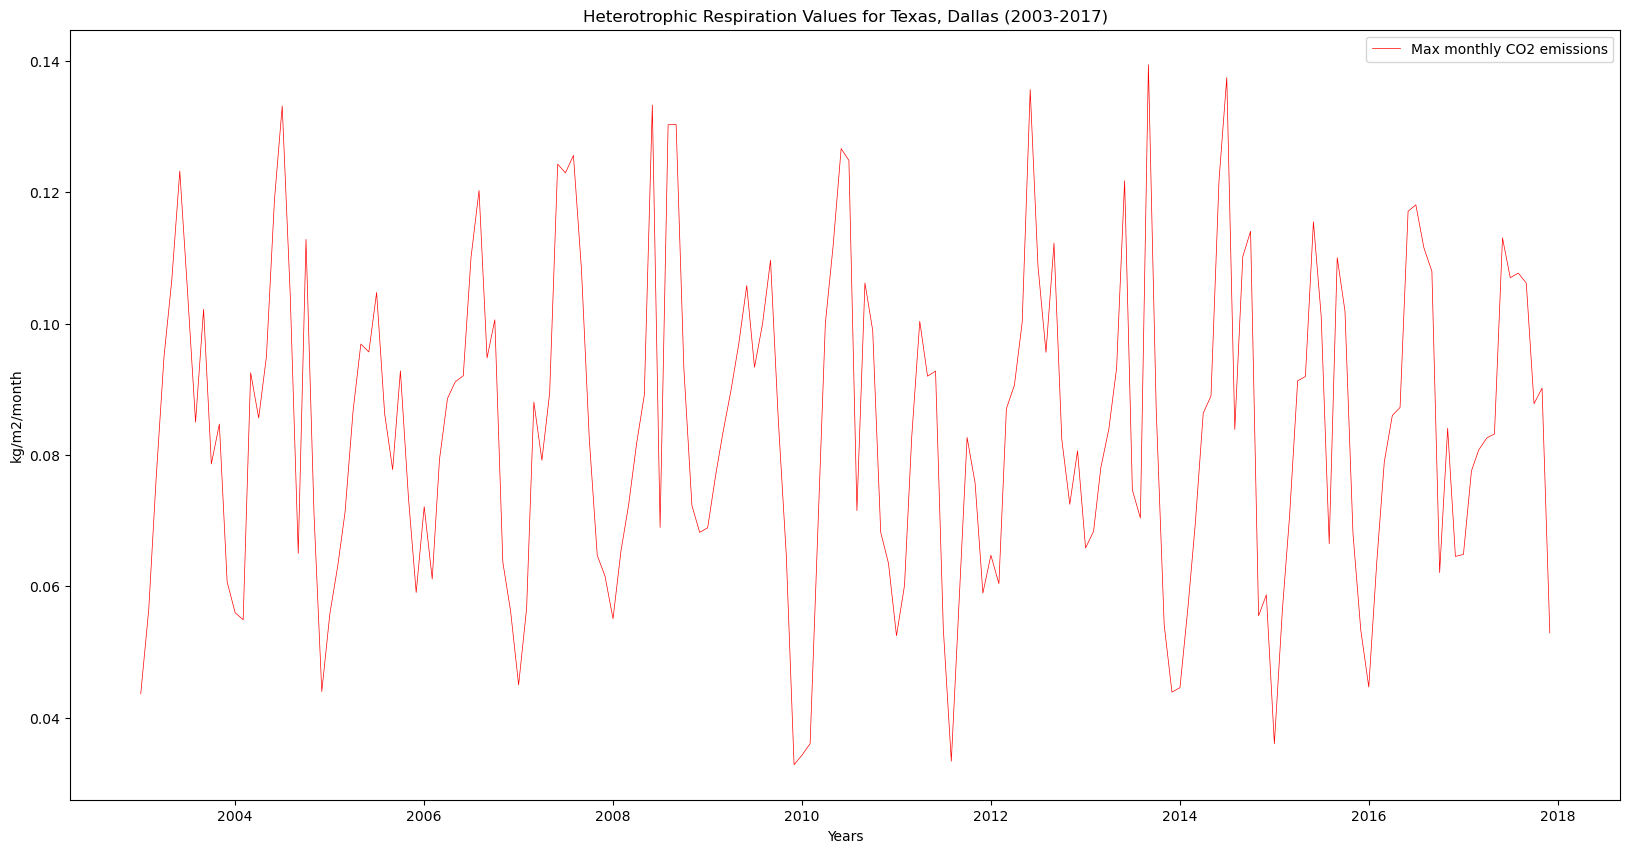

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["date"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Max monthly CO2 emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("kg/m2/month")
plt.title("Heterotrophic Respiration Values for Texas, Dallas (2003-2017)")

In [21]:
print(items[2]["properties"]["start_datetime"])

2017-10-01T00:00:00+00:00


In [22]:
october_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
october_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nasa-casa-gfed-co2-flux&item=nasa-casa-gfed-co2-flux-201710&assets=rh&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C0.6039900183677673'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [23]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        -22.421460,
        14.268801,
    ],
    zoom_start=8,
)

map_layer = TileLayer(
    tiles=october_tile["tiles"][0],
    attr="GHG", opacity = 0.8
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook, we have successfully explored, analyzed, and visualized the STAC collection for CASA GFED Land-Atmosphere CO₂ Flux.